In [30]:
from pathlib import Path
import sys
# Add the scripts directory to the path
scripts_path = Path.cwd().parent / "scripts"
sys.path.append(str(scripts_path))

# Reload the module (in case you had an old version)
import importlib
import load_data
importlib.reload(load_data)

# Load data for Subject 2
signal, labels = load_data.load_data("2")
print("Data loaded successfully!")
print("\nSignal keys:", signal.keys())
print("\nFirst few labels:", labels[:5])

Data loaded successfully!

Signal keys: dict_keys(['chest', 'wrist'])

First few labels: [0 0 0 0 0]


In [31]:
print(signal['chest'].keys())  # ECG, EDA, EMG, TEMP, RESP, ACC
print(signal['wrist'].keys())  # ACC, BVP, EDA, TEMP

dict_keys([b'ACC', b'ECG', b'EMG', b'EDA', b'Temp', b'Resp'])
dict_keys([b'ACC', b'BVP', b'EDA', b'TEMP'])


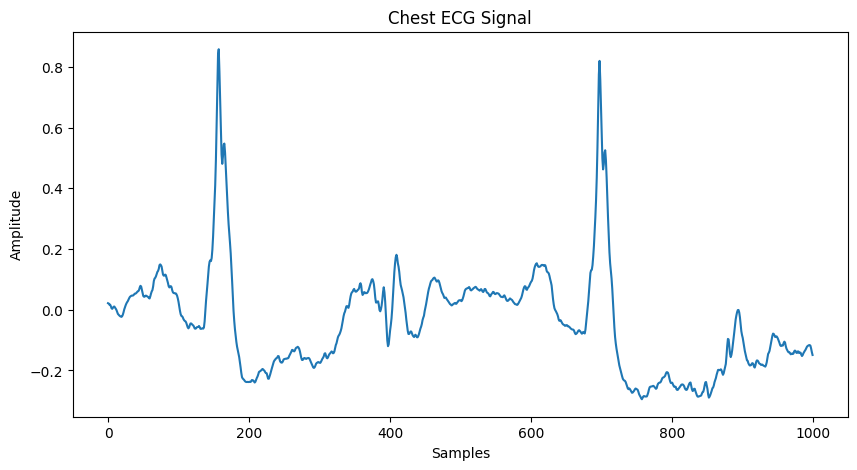

In [33]:
import matplotlib.pyplot as plt

# Plot 1000 samples of chest ECG
plt.figure(figsize=(10, 5))
plt.plot(signal['chest'][b'ECG'][:1000])
plt.title("Chest ECG Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [35]:
selected_signals = {
    'chest': {
        'ECG': signal['chest'][b'ECG'],
        'EDA': signal['chest'][b'EDA'],
        'Resp': signal['chest'][b'Resp']
    },
    'wrist': {
        'BVP': signal['wrist'][b'BVP'],
        'EDA': signal['wrist'][b'EDA']
    }
}

In [36]:
ecg_normalized = ((selected_signals['chest']['ECG'] / (2**16)) - 0.5) * 3
eda_normalized = ((selected_signals['chest']['EDA'] / (2**16)) * 3) / 0.12
resp_normalized = (selected_signals['chest']['Resp'] / (2**16) - 0.5) * 100

In [37]:
from scipy.signal import resample

# Resample ECG from 700 Hz to 4 Hz
ecg_resampled = resample(ecg_normalized, len(ecg_normalized) // 175)

In [44]:
# Use a larger window size for segmentation
window_size = 21000  # 30 seconds at 700 Hz
overlap = 0.5  # 50% overlap

def segment_data(data, window_size, overlap):
    step = int(window_size * (1 - overlap))
    segments = [data[i:i + window_size] for i in range(0, len(data) - window_size, step)]
    return segments

ecg_segments = segment_data(ecg_normalized, window_size, overlap)
print(f"Number of segments: {len(ecg_segments)}")
print(f"Length of each segment: {len(ecg_segments[0])}")


ecg_segments = segment_data(ecg_resampled, window_size, overlap)
print(f"Number of ECG segments: {len(ecg_segments)}")

Number of segments: 404
Length of each segment: 21000
Number of ECG segments: 1


In [45]:
import neurokit2 as nk

# Step 1: Clean the ECG signal
ecg_cleaned = nk.ecg_clean(ecg_normalized, sampling_rate=700)

# Step 2: Extract R-peaks
_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=700)

# rpeaks is a dictionary containing the indices of R-peaks
print(rpeaks["ECG_R_Peaks"][:10])  # Print the first 10 R-peak indices

[ 699 1208 1745 2378 3002 3637 4267 4831 5393 5940]


In [46]:
# Compute HRV features
hrv_features = nk.hrv_time(rpeaks, sampling_rate=700)
print(hrv_features.head())  # Display the first few HRV features

   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  838.375737  137.040536   54.759516   97.488698   52.669105  106.042834   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...   HRV_IQRNN  \
0    45.82114  100.822921  157.644553  157.655425  ...  122.857143   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN  \
0     0.869301   758.571429   912.857143  34.639261  69.223341  305.714286   

     HRV_MaxNN    HRV_HTI  HRV_TINN  
0  6444.285714  25.889286       0.0  

[1 rows x 25 columns]


In [47]:
hrv_features_all = []

for segment in ecg_segments:  # Assume `ecg_segments` contains segmented ECG windows
    ecg_cleaned = nk.ecg_clean(segment, sampling_rate=700)
    _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=700)
    hrv_features = nk.hrv_time(rpeaks, sampling_rate=700)
    hrv_features_all.append(hrv_features)

# Convert the list of DataFrames to a single DataFrame
import pandas as pd
hrv_features_df = pd.concat(hrv_features_all, ignore_index=True)
print(hrv_features_df.head())

   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1135.77381  600.656766         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...   HRV_IQRNN  \
0         NaN         NaN  776.603245  793.909664  ...  576.071429   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN  \
0     0.773441   693.142857  1533.142857  91.666667  91.666667  411.428571   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     2420.0     12.0  351.5625  

[1 rows x 25 columns]
